In [1]:
import pandas as pd
skin = pd.read_csv("data/skin_data2.csv")

In [2]:
skin["Product Link"].to_csv("product_links.csv", index=False, header=False)

In [7]:
# Uzun metinlerin tamamını görmek için pandas ayarlarını değiştirme
pd.set_option('display.max_colwidth', None)

# Şimdi, reviews sütununu görmek için
print(skin["Reviews"].iloc[0:1])

0    ["I have oily skin this product does help with mattifying but caused breakouts. I used it several weeks hoping my skin would adjust to using this product but it didn't.", 'I have a mixed skin tone and so none of the shades were a great match for me. They werent way. I mean its not like it was 5 shades to light… I just didnt love how it looked on me when i wore it by itself cause i though it made me look whiter. I also dont think that its worth the price. I dont hate this though, its great for my oily skin! I personally just think there are better sunscreens for a better price in my opinon. I will say i think everyone should try this especially if youve got oily skin!', "I've tried so many sunscreens, both mineral and chemical but I would either break out, have oily skin all day, a WHITE cast, or my foundation would just look bad. This feel like you're applying primer, and my fenty powdered foundation looks really great on top of it. My makeup doesn't look muddy after wearing it fo

GENERATE IMAGE LINKS


In [16]:
import re
import pandas as pd

def generate_image_links(product_links):
    base_url = "https://media.ulta.com/i/ulta/"
    image_params = "?w=1080&h=1080&fmt=auto"
    id_pattern = re.compile(r"sku=(\d+)")
    
    image_links = [] 

    for i, link in enumerate(product_links):
        print(f"Processing link {i+1}: {link}") 
        match = id_pattern.search(link)
        if match:
            product_id = match.group(1)
            image_link = f"{base_url}{product_id}{image_params}" 
            image_links.append(image_link) 
        else:
            print(f"Link {i+1} does not match regex pattern: {link}") 
            image_links.append(None) 
    
    return image_links

product_links = skin['Product Link'].tolist()

image_links = generate_image_links(product_links)

skin['Image Link'] = image_links

skin.to_csv("data.csv", index=False)



Processing link 1: https://www.ulta.com/p/mineral-mattescreen-spf-40-pimprod2029941?sku=2589388#reviews
Processing link 2: https://www.ulta.com/p/cryo-flash-instant-lift-effect-glow-boosting-face-mask-pimprod2040118?sku=2612180#reviews
Processing link 3: https://www.ulta.com/p/moisture-surge-100h-auto-replenishing-hydrator-gel-moisturizer-with-hyaluronic-acid-pimprod2021615?sku=2576544#reviews
Processing link 4: https://www.ulta.com/p/glycolic-acid-7-exfoliating-toner-pimprod2007097?sku=2551155#reviews
Processing link 5: https://www.ulta.com/p/niacinamide-10-zinc-1-brightening-serum-pimprod2007111?sku=2551167#reviews
Processing link 6: https://www.ulta.com/p/cliniques-most-loved-skincare-makeup-set-65-with-any-clinique-purchase-pimprod2047428?sku=2627622#reviews
Processing link 7: https://www.ulta.com/p/unseen-sunscreen-spf-40-pimprod2029930?sku=2589386#reviews
Processing link 8: https://www.ulta.com/p/toleriane-purifying-foaming-face-wash-oily-skin-xlsImpprod15321287?sku=2503388#revie

CATEGORIZE PRODUCTS WITH NLTK


In [17]:
pip install pandas nltk


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import nltk
import re
nltk.download('vader_lexicon')

reviews = pd.read_csv("data/reviews.csv")["Reviews"]
columns = [
    "Skin Type Compatibility",
    "Ingredients",
    "Ease of Use",
    "Scent",
    "Effectiveness"
]

categorized_reviews = []

def categorize_reviews(review):

    skin_types = ["Oily", "Dry", "Combination", "Normal", "Sensitive", "Acne", "Aging", "Eczema"]
    skin_type = [skin for skin in skin_types if skin.lower() in review.lower()]
    skin_type = ', '.join(skin_type) if skin_type else "Unknown"

    ingredients = re.search(r"(vitamin c|hyaluronic acid|retinol|shea butter)", review, re.IGNORECASE)
    ingredients = ingredients.group(0) if ingredients else "Unknown"

    ease_of_use = "Easy" if "easy" in review.lower() else "Difficult"

    scent = "Strong" if "strong" in review.lower() else "Light"

    effectiveness = "Effective" if "works" in review.lower() else "Ineffective"

    return {
        "Skin Type Compatibility": skin_type,
        "Ingredients": ingredients,
        "Ease of Use": ease_of_use,
        "Scent": scent,
        "Effectiveness": effectiveness
    }

for review in reviews:
    categorized_review = categorize_reviews(review)
    categorized_reviews.append(categorized_review)

df = pd.DataFrame(categorized_reviews, columns=columns)
df.to_csv("categorized_reviews.csv", index=False)

combined = pd.concat([skin, df], axis=1)
combined = combined[combined['Reviews'].apply(lambda x: x != '[]')]
combined.to_csv("final_data.csv", index=False)
ulta_data = pd.read_csv("final_data.csv")
ulta_data = ulta_data.drop_duplicates()
ulta_data.to_csv("final_data_cleaned.csv", index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/esra/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TOP 10 PRODUCT NAMES


In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(review):
    return sia.polarity_scores(review)["compound"]

ulta_data['Sentiment'] = ulta_data['Reviews'].apply(get_sentiment_score)

product_sentiment = ulta_data.groupby(
    ['Product Name', 'Image Link', 'Product Link']
).agg(
    average_sentiment=('Sentiment', 'mean'),
    review_count=('Reviews', 'count')
).reset_index()

sorted_products = product_sentiment.sort_values(
    by=['review_count', 'average_sentiment'], ascending=[False, False]
)

top_20_products = sorted_products.head(21)
top_20_products.to_csv("top_20_products.csv", index=False)


DATA ANALYSIS

In [18]:
ingredients_vs_effectiveness = ulta_data.groupby(['Ingredients', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applymap(lambda x: f"{x:.1f}%")
brand_effectiveness = ulta_data.groupby(['Product Brand', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applymap(lambda x: f"{x:.1f}%")
ingredients_effectiveness_correlation = ulta_data.groupby(['Ingredients', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applymap(lambda x: f"{x:.1f}%")

/var/folders/lg/dgwnwk9d0d3874nd4j_wdz080000gn/T/ipykernel_53460/3894072577.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ingredients_vs_effectiveness = ulta_data.groupby(['Ingredients', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applymap(lambda x: f"{x:.1f}%")
/var/folders/lg/dgwnwk9d0d3874nd4j_wdz080000gn/T/ipykernel_53460/3894072577.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  brand_effectiveness = ulta_data.groupby(['Product Brand', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applymap(lambda x: f"{x:.1f}%")
/var/folders/lg/dgwnwk9d0d3874nd4j_wdz080000gn/T/ipykernel_53460/3894072577.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ingredients_effectiveness_correlation = ulta_data.groupby(['Ingredients', 'Effectiveness']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).applyma

In [123]:
brand_effectiveness

Effectiveness,Effective,Ineffective
Product Brand,,
ACURE,100.000000,NaN
Ahava,75.000000,25.000000
AmLactin,100.000000,NaN
Anastasia Beverly Hills,100.000000,NaN
Andalou Naturals,57.142857,42.857143
...,...,...
kaia naturals,100.000000,NaN
ma:nyo,44.444444,55.555556
megababe,100.000000,NaN


In [124]:
ingredients_effectiveness_correlation

Effectiveness,Effective,Ineffective
Ingredients,,
HYALURONIC ACID,100.000000,NaN
Hyaluronic Acid,92.592593,7.407407
Hyaluronic acid,92.592593,7.407407
Retinol,89.024390,10.975610
SHEA BUTTER,100.000000,NaN
Shea Butter,100.000000,NaN
Shea butter,85.714286,14.285714
Unknown,75.796178,24.203822
VITAMIN C,100.000000,NaN


In [20]:
import numpy as np

EDA

In [31]:
counts_brand = ulta_data['Product Brand'].value_counts()
count_percentage = ulta_data['Product Brand'].value_counts(1)*100
counts_dfbrand = pd.DataFrame({'Brand':counts_brand.index,'Counts':counts_brand.values,'Percent%':np.round(count_percentage.values,2)})
top_10_brands = counts_dfbrand.head(10)
top_10_brands

,Brand,Counts,Percent%
0,Clinique,157,3.75
1,Dermalogica,87,2.08
2,La Roche-Posay,77,1.84
3,Mario Badescu,71,1.70
4,Kiehl's Since 1851,69,1.65
5,Neutrogena,61,1.46
6,The Ordinary,60,1.43
7,The Crème Shop,59,1.41
8,Estée Lauder,55,1.31
9,Murad,53,1.27


/var/folders/lg/dgwnwk9d0d3874nd4j_wdz080000gn/T/ipykernel_53460/401597342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Brand', y='Counts', width = 0.6, data=top_10_brands, palette='magma')


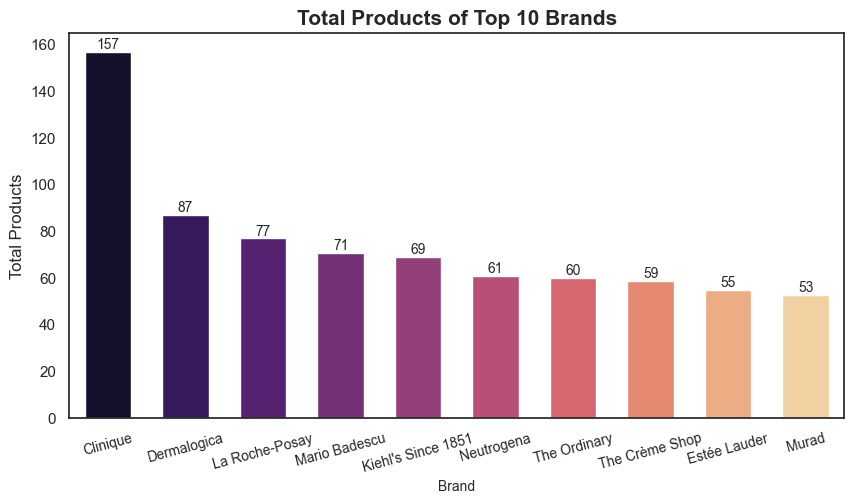

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Brand', y='Counts', width = 0.6, data=top_10_brands, palette='magma')
ax.set_title('Total Products of Top 10 Brands', fontsize=15, fontweight='bold')
ax.set_xlabel('Brand', fontsize=10, fontweight='medium')
ax.set_ylabel('Total Products', fontsize=12, fontweight='medium')
for label in ax.containers:
    ax.bar_label(label, fontweight='medium', fontsize=10)
plt.xticks(rotation = 15, fontsize=10)
plt.show()

In [37]:
ulta_data.drop_duplicates(inplace=True)